In [4]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
from selenium.webdriver.firefox.service import Service
import PRIVATE
import random
import re
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import random
from selenium.common.exceptions import NoSuchElementException
import sqlite3
import os
import pandas as pd

In [14]:
df = pd.read_csv("./test-csv/df_result.csv", encoding="CP949")

# lecNumLists = df['학정번호'].tolist()[:3] # 테스트용으로 3개만 남김
lecNumLists = df['학정번호'].tolist()

print(lecNumLists)

['0000-1-8128-01', '0000-1-8128-02', '7000-1-3362-01', '7000-1-3362-02', '7000-1-3362-03', '7000-1-3362-04', '7000-1-3362-05', '7000-1-3362-06', '7000-1-3362-07', '7000-1-3362-08', '7000-1-3362-09', '7000-1-3362-10', '7000-1-3362-11', '7000-1-3362-12', '7000-1-3362-13', '7000-1-3362-14', '7000-1-3362-15', '7000-1-3362-16', '7000-1-3362-17', '6000-1-3362-01', '6000-1-3362-02', '6000-1-3362-03', '6000-1-3362-04', '6000-1-3362-05', '6000-1-3362-06', 'F000-1-3362-01', 'F000-1-3362-02', 'F000-1-3362-03', 'F000-1-3362-04', 'F000-1-3362-05']


In [15]:
def sleep_time(min_sec, max_sec):
    time.sleep(random.uniform(min_sec,max_sec))
    driver.implicitly_wait(random.uniform(min_sec,max_sec))
  
def find_n_click(xpath):
    element = driver.find_element(By.XPATH, xpath)
    element.click()
    sleep_time(1,2) 

def find_n_get_text(xpath):
    """xpath selector"""
    return WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, xpath))).text

def get_href(xpath):
    element = driver.find_element(By.XPATH, xpath)
    href = element.get_attribute("href")
    return href

def find_n_get_review_page(lecNum):
    driver.get('https://everytime.kr/timetable/2024/1')
    sleep_time(1,2) 

    find_n_click("/html/body/div[1]/ul/li[1]") #수업목록에서 검색 버튼
    find_n_click("/html/body/div[2]/div[1]/a[4]") #검색어 버튼
    find_n_click("/html/body/div[1]/form[5]/div/label[3]") #과목 코드 버튼

    input_element = driver.find_element(By.XPATH, '/html/body/div[1]/form[5]/div/input') #input에 클릭
    input_element.send_keys(lecNum) #값 넣기
    sleep_time(0.5, 1) 

    find_n_click("/html/body/div[1]/form[5]/input")
    sleep_time(2, 3) 

    xpath = "/html/body/div[2]/div[2]/table/tbody/tr/td[7]/a" #강의평 url 얻기
    href = get_href(xpath)
    print("url:",href)

    return href

def everytime_login(id, pw):
    driver.get("https://account.everytime.kr/login")
    sleep_time(1,2)

    driver.find_element(By.NAME, 'id').send_keys(id)
    driver.find_element(By.NAME, 'password').send_keys(pw)
    sleep_time(1,2)

    driver.find_element(By.CSS_SELECTOR, '.container > form:nth-child(2) > input:nth-child(2)').click()
    sleep_time(1,2)

def get_reviews(url, lecNum):
    driver.get(f"{url}?tab=article")
    sleep_time(2, 3)

    reviews_dict = {}
    index = 1

    while True:
        try:
            sleep_time(0.1,0.5)
            review_xpath = f"/html/body/div/div/div[2]/div/div[2]/div[{index}]/div[2]"
            reviewer_xpath = f"/html/body/div/div/div[2]/div/div[2]/div[{index}]/div[1]/div[1]/div[2]/span[1]"
            stars_xpath = f"/html/body/div/div/div[2]/div/div[2]/div[{index}]/div[1]/div[1]/div[1]/span/span"

            stars_element = driver.find_element(By.XPATH, stars_xpath)
            style = stars_element.get_attribute("style")
            width_value = style.split("width: ")[1].split(";")[0]
            stars = (int(width_value.strip().replace("%", ""))) / 20 

            reviewer_element = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.XPATH, reviewer_xpath))
            )
            reviewer = reviewer_element.text

            review_element = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.XPATH, review_xpath))
            )
            review = review_element.text

            reviews_dict[f"review{index}"] = {
                'reviewer': reviewer,
                'stars': stars,
                'review': review
            }

            index += 1
        except Exception as e:
            break

    for key, review_data in reviews_dict.items():
        print(f"\n{key}:")
        print(f"reviewer: {review_data['reviewer']}")
        print(f"stars: {review_data['stars']}")
        print(f"review: {review_data['review']}")

        cursor.execute('''
            INSERT INTO LecReviewTable (lecNumber, lecReviewrs, lecStars, lecReview)
            VALUES (?, ?, ?, ?)
        ''', (lecNum, review_data['reviewer'], review_data['stars'], review_data['review']))
        conn.commit()

def driver_setting():
    driver_path = "./gecko/geckodriver"
    options = webdriver.FirefoxOptions()
    # options.add_argument('--headless')
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("user-agent={Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36}")

    service = Service(executable_path=driver_path)
    driver = webdriver.Firefox(service=service, options=options)

    return driver

###########################

def get_assignment_average():
    assignment_high = int(find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div/div[1]/div[2]").strip().replace("%", ""))
    assignment_mid = int(find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div/div[2]/div[2]").strip().replace("%", ""))
    assignment_low = int(find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div/div[3]/div[2]").strip().replace("%", ""))
    return (assignment_high*100 + assignment_mid*50 + assignment_low*0)/100

def get_group_work_average():
    group_work_high = int(find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[2]/div/div[1]/div[2]").strip().replace("%", ""))
    group_work_mid = int(find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[2]/div/div[2]/div[2]").strip().replace("%", ""))
    group_work_low = int(find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[2]/div/div[3]/div[2]").strip().replace("%", ""))
    return (group_work_high*100 + group_work_mid*50 + group_work_low*0)/100

def get_grade_average():
    grade_high = int(find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[3]/div/div[1]/div[2]").strip().replace("%", ""))
    grade_mid = int(find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[3]/div/div[2]/div[2]").strip().replace("%", ""))
    grade_low = int(find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[3]/div/div[3]/div[2]").strip().replace("%", ""))
    return (grade_high*100 + grade_mid*50 + grade_low*0)/100

def print_lecture_data(score, assignment_average, group_work_average, grade_average, chul_geul, test_num):
    print(f"전체 평점: {score}")
    print(f"과제 평균 점수: {assignment_average}")
    print(f"조모임: {group_work_average}")
    print(f"성적: {grade_average}")
    print(f"출결: {chul_geul}")
    print(f"시험 횟수: {test_num}")

###########################

db_folder = "./database"
db_path = os.path.join(db_folder, "lecture.db")
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# LectureTable
cursor.execute('''
CREATE TABLE IF NOT EXISTS LectureTable (
    lecNumber TEXT PRIMARY KEY,
    lecUrl INTEGER,
    lecClassification TEXT,
    lecClassName TEXT,
    lecSubName TEXT,
    lecProfessor TEXT,
    lecStars FLOAT,
    lecAssignment FLOAT,
    lecTeamplay FLOAT,
    lecGrade FLOAT,
    lecMajor TEXT,
    lecSummaryReview TEXT,
    lecAttend TEXT,
    lecTestNum TEXT,
    lecLastYear1PeopleNum INTEGER,
    lecLastYear2PeopleNum INTEGER,
    lecLastYear3PeopleNum INTEGER
)
''')

# LecReviewTable
cursor.execute('''
CREATE TABLE IF NOT EXISTS LecReviewTable (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    lecNumber TEXT,
    lecReviewrs TEXT,
    lecStars INTEGER,
    lecReview TEXT,
    FOREIGN KEY (lecNumber) REFERENCES LectureTable (lecNumber)
)
''')

driver = driver_setting()

everytime_login(PRIVATE.EVERYTIME_ID, PRIVATE.EVERYTIME_PW)

try:
    for lecNum in lecNumLists:
        href = find_n_get_review_page(lecNum)
        driver.get(href)

        match = re.search(r'/(\d+)$', href)
        if match:
            review_id = match.group(1)
        else:
            continue

        cursor.execute('INSERT OR IGNORE INTO LectureTable (lecNumber) VALUES (?)', (lecNum,))

        try:
            case1 = driver.find_element(By.XPATH, '/html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div[1]/span')
            try:
                score = WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, "body div div.container div.pane div.info_tab section.review div.rating div.title span.average"))
                ).text

                assignment = find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div[1]/span")
                group_work = find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div[2]/span")
                grade = find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div[3]/span")
                chul_geul = find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[2]/div/span")
                test_num = find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[3]/div/span")
                prof_name = find_n_get_text("/html/body/div/div/div[2]/div/section[1]/div[2]/div/a/span")
                class_name = find_n_get_text("/html/body/div/div/div[2]/div/section[1]/div[1]/a/span")

                print_lecture_data(score, assignment, group_work, grade, chul_geul, test_num)

                cursor.execute('''
                    UPDATE LectureTable 
                    SET lecStars = ?, lecUrl = ?, lecAssignment = ?, lecTeamplay = ?, lecGrade = ?, lecAttend = ?, lecTestNum = ?, lecProfessor = ?, lecClassName = ?
                    WHERE lecNumber = ?
                ''', (score, review_id, assignment, group_work, grade, chul_geul, test_num, prof_name, class_name, lecNum))
                conn.commit()

            except Exception as e:
                pass

            get_reviews(href, lecNum)

        except NoSuchElementException:
            pass

        try:
            case2 = driver.find_element(By.XPATH, '/html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div/div[1]/div[2]')
            try:
                score = find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[1]/div[1]/span[1]")
                print(f"score: {score}")

                assignment_average = get_assignment_average()
                group_work_average = get_group_work_average()
                grade_average = get_grade_average()

                chul_geul_element = driver.find_element(By.XPATH, '/html/body/div/div/div[2]/div/section[2]/div[2]/div[4]/div//span[contains(@class, "majority")]')
                chul_geul = chul_geul_element.text

                test_num = driver.find_element(By.XPATH, '/html/body/div/div/div[2]/div/section[2]/div[2]/div[5]/div//span[contains(@class, "majority")]')
                test_num = test_num.text

                prof_name = find_n_get_text("/html/body/div/div/div[2]/div/section[1]/div[2]/div/a/span")
                class_name = find_n_get_text("/html/body/div/div/div[2]/div/section[1]/div[1]/a/span")

                print_lecture_data(score, assignment_average, group_work_average, grade_average, chul_geul, test_num)

                cursor.execute('''
                    UPDATE LectureTable 
                    SET lecStars = ?, lecUrl = ?, lecAssignment = ?, lecTeamplay = ?, lecGrade = ?, lecAttend = ?, lecTestNum = ?, lecProfessor = ?, lecClassName = ?
                    WHERE lecNumber = ?
                ''', (score, review_id, assignment_average, group_work_average, grade_average, chul_geul, test_num, prof_name, class_name, lecNum))
                conn.commit()

            except Exception as e:
                pass

            get_reviews(href, lecNum)

        except NoSuchElementException:
            pass

finally:
    conn.commit()
    conn.close()
    time.sleep(10)
    driver.quit()

url: https://everytime.kr/lecture/view/2314908
score: 4.91
전체 평점: 4.91
과제 평균 점수: 67.0
조모임: 95.0
성적: 97.0
출결: 전자출결
시험 횟수: 없음

review1:
reviewer: 24년 1학기 수강자
stars: 5.0
review: 강의만 온라인으로 다 들으면 pass주는 과목입니다. 1학점 챙겨가세요

review2:
reviewer: 24년 여름 수강자
stars: 5.0
review: 온라인강의 꿀! 학기 말에 몰아서 하면 됩니다!!

review3:
reviewer: 24년 1학기 수강자
stars: 5.0
review: 강의만 수강하시면 패스 충분히 받습니다. 온라인 강의라 부담이 없습니다

review4:
reviewer: 24년 1학기 수강자
stars: 5.0
review: 강의 제때제때 틀어놓는 거랑 공지사항 내용 꼼꼼히 확인하기만 하면 쉽게 패스 가능합니다

review5:
reviewer: 24년 1학기 수강자
stars: 4.0
review: 강의 시청기간만 잘 지켜서 틀어두기만 하세요. 강의 시청이 출석입니다. 과제는 초반에 간단한 이력서? 작성 하나랑 검사 2,3개 정도 있는데 이것도 기간 잘 맞춰서 하시구요. 이력서 열심히 작성 안 하셔도 됩니다. 대신 강의 시청기간이 나중 갈 수록 점점 짧아져서 깜빡하면 기간 지나니까 주의하세요.

review6:
reviewer: 24년 1학기 수강자
stars: 5.0
review: 간단한 과제 몇 개와 영상만 다 틀어놓으면 1학점 챙겨가는 강의입니다

review7:
reviewer: 24년 1학기 수강자
stars: 3.0
review: 그냥 영상만 틀어놓으면 됨
딱히 준비할 거 없음
시험 없음

review8:
reviewer: 24년 1학기 수강자
stars: 4.0
review: 그냥 틀어놓으면 됩니다. 들으면 도움될만한 내용인데 온라인이어서 그런지 듣게 되지는 않아요! 다만 수강신청이 굉장히 빡셀뿐입니다


- str: lecNumber - 강의번호
- int: lecUrl - 에타 번호
- str: lecClassification - 강의분류
- str: lecClassName - 강의명
- str: lecSubName - 과목명
- str: lecProfessor - 교수명
- flt: lecStars - 별점
- flt: lecAssignment - 과제
- flt: lecTeamplay - 조모임
- flt: lecGrade - 성적
- str: lecMajor - 전공
- str: lecSummaryReview - 요약 리뷰
- str: lecAttend - 출결
- int: lecLastYear1PeopleNum - 1년전인원
- int: lecLastYear2PeopleNum - 2년전인원
- int: lecLastYear3PeopleNum - 3년전인원

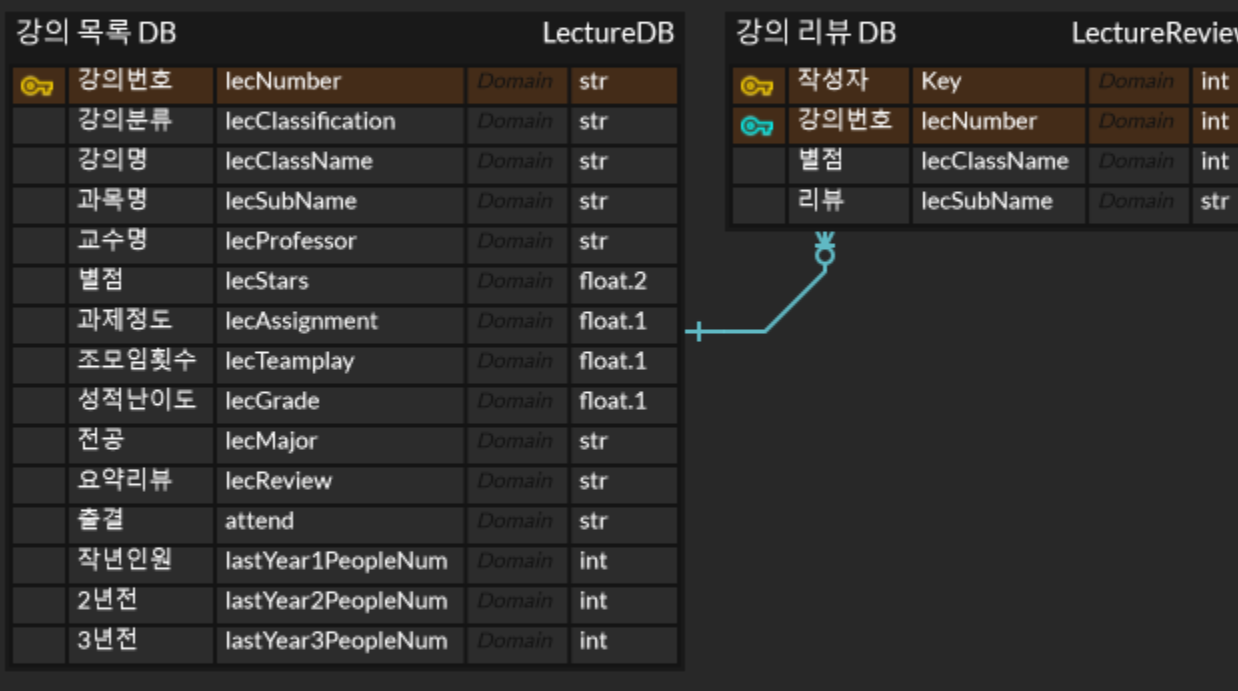


---


### fill missing data


In [32]:
conn = sqlite3.connect('./database/lecture-3.db')
cursor = conn.cursor()

df = pd.read_csv("../data_preprocessing/lec-timetable-final.csv", encoding="CP949")

lecNumLists = df['학정번호'].tolist()

query = '''
SELECT lecNumber
FROM LectureTable
WHERE lecNumber IN ({})
AND lecUrl IS NULL
'''.format(','.join(['?']*len(lecNumLists)))

cursor.execute(query, lecNumLists)
result = cursor.fetchall()

lecNumWithoutUrl = [row[0] for row in result]

conn.close()

print(lecNumWithoutUrl)

['0000-1-3414-10', '0000-1-3414-11', '0000-1-3414-13', '0000-1-3415-02', '0000-1-3589-01', '0000-1-3589-02', '0000-1-3593-13', '0000-1-3593-15', '0000-1-3671-01', '0000-1-3675-01', '0000-1-3814-02', '0000-1-3902-01', '0000-1-3925-01', '0000-1-3928-01', '0000-1-3948-01', '0000-1-4101-02', '0000-1-4101-03', '0000-1-4120-01', '0000-1-4120-02', '0000-1-4625-02', '0000-1-4625-05', '0000-1-4625-07', '0000-1-4625-12', '0000-1-4625-14', '0000-1-4625-15', '0000-1-4625-16', '0000-1-4625-17', '0000-1-4625-20', '0000-1-4625-21', '0000-1-4628-01', '0000-1-4628-05', '0000-1-4830-01', '0000-1-4831-01', '0000-1-4837-02', '0000-1-4849-02', '0000-1-4853-01', '0000-1-4854-01', '0000-1-4887-01', '0000-1-5220-01', '0000-1-5378-03', '0000-1-5660-02', '0000-1-5674-01', '0000-1-5678-01', '0000-1-5678-02', '0000-1-5899-01', '0000-1-7132-01', '0000-1-7466-02', '0000-1-8085-02', '0000-1-8085-03', '0000-1-9255-01', '0000-1-9753-03', '0000-1-9753-04', '0000-1-9753-05', '0000-1-9753-06', '0000-1-9753-07', '0000-1-9

In [37]:
from sqlalchemy import Null
from selenium.common.exceptions import TimeoutException

def sleep_time(min_sec, max_sec):
    time.sleep(random.uniform(min_sec,max_sec))
    driver.implicitly_wait(random.uniform(min_sec,max_sec))
  
def find_n_click(xpath):
    element = driver.find_element(By.XPATH, xpath)
    element.click()
    sleep_time(1,2) 

def find_n_get_text(xpath):
    try:
        texted = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, xpath))).text
        if texted == "":
            texted = None
        return texted
    except TimeoutException:
        return None
    
def get_href(xpath):
    element = driver.find_element(By.XPATH, xpath)
    href = element.get_attribute("href")
    return href

def find_n_get_review_page(lecNum):
    driver.get('https://everytime.kr/timetable/2024/1')
    sleep_time(1,2) 

    find_n_click("/html/body/div[1]/ul/li[1]") #수업목록에서 검색 버튼
    find_n_click("/html/body/div[2]/div[1]/a[4]") #검색어 버튼
    find_n_click("/html/body/div[1]/form[5]/div/label[3]") #과목 코드 버튼

    input_element = driver.find_element(By.XPATH, '/html/body/div[1]/form[5]/div/input') #input에 클릭
    input_element.send_keys(lecNum) #값 넣기
    sleep_time(0.5, 1) 

    find_n_click("/html/body/div[1]/form[5]/input")
    sleep_time(2, 3) 

    xpath = "/html/body/div[2]/div[2]/table/tbody/tr/td[7]/a" #강의평 url 얻기
    href = get_href(xpath)
    print("url:",href)

    return href

def everytime_login(id, pw):
    driver.get("https://account.everytime.kr/login")
    sleep_time(1,2)

    driver.find_element(By.NAME, 'id').send_keys(id)
    driver.find_element(By.NAME, 'password').send_keys(pw)
    sleep_time(1,2)

    driver.find_element(By.CSS_SELECTOR, '.container > form:nth-child(2) > input:nth-child(2)').click()
    sleep_time(1,2)

def get_reviews(url, lecNum):
    driver.get(f"{url}?tab=article")
    sleep_time(2, 3)

    reviews_dict = {}
    index = 1

    score = find_n_get_text("/html/body/div/div/div[2]/div/div[1]/div[1]/span[1]")

    cursor.execute('''
        UPDATE LectureTable 
        SET lecStars = ?
        WHERE lecNumber = ?
    ''', (score, lecNum))
    conn.commit()
    print(f"lec score: {score}, commited!\n")

    while True:
        try:
            sleep_time(0.1,0.5)
            review_xpath = f"/html/body/div/div/div[2]/div/div[2]/div[{index}]/div[2]"
            reviewer_xpath = f"/html/body/div/div/div[2]/div/div[2]/div[{index}]/div[1]/div[1]/div[2]/span[1]"
            stars_xpath = f"/html/body/div/div/div[2]/div/div[2]/div[{index}]/div[1]/div[1]/div[1]/span/span"

            stars_element = driver.find_element(By.XPATH, stars_xpath)
            style = stars_element.get_attribute("style")
            width_value = style.split("width: ")[1].split(";")[0]
            stars = (int(width_value.strip().replace("%", ""))) / 20 

            reviewer_element = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.XPATH, reviewer_xpath))
            )
            reviewer = reviewer_element.text

            review_element = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.XPATH, review_xpath))
            )
            review = review_element.text

            reviews_dict[f"review{index}"] = {
                'reviewer': reviewer,
                'stars': stars,
                'review': review
            }

            index += 1
        except Exception as e:
            break

    for key, review_data in reviews_dict.items():
        try:
            cursor.execute('''
                INSERT INTO LecReviewTable (lecNumber, lecReviewrs, lecStars, lecReview)
                VALUES (?, ?, ?, ?)
            ''', (lecNum, review_data['reviewer'], review_data['stars'], review_data['review']))
            conn.commit()
            
            review_text = review_data['review']
            review_text = review_text.replace('\n', ' ')
            if len(review_text) > 30:
                truncated_review = review_text[:30] + '...'
            else:
                truncated_review = review_text

            print(f"{key}  \t| {review_data['reviewer']} | {review_data['stars']} | {truncated_review}")

        except Exception as e:
            print(f"unexpected error at reveiw: {e}")

def driver_setting():
    driver_path = "./gecko/geckodriver"
    options = webdriver.FirefoxOptions()
    # options.add_argument('--headless')
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("user-agent={Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36}")

    service = Service(executable_path=driver_path)
    driver = webdriver.Firefox(service=service, options=options)

    return driver

###########################

def get_assignment_average():
    assignment_high = int(find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div/div[1]/div[2]").strip().replace("%", ""))
    assignment_mid = int(find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div/div[2]/div[2]").strip().replace("%", ""))
    assignment_low = int(find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div/div[3]/div[2]").strip().replace("%", ""))
    return (assignment_high*100 + assignment_mid*50 + assignment_low*0)/100

def get_group_work_average():
    group_work_high = int(find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[2]/div/div[1]/div[2]").strip().replace("%", ""))
    group_work_mid = int(find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[2]/div/div[2]/div[2]").strip().replace("%", ""))
    group_work_low = int(find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[2]/div/div[3]/div[2]").strip().replace("%", ""))
    return (group_work_high*100 + group_work_mid*50 + group_work_low*0)/100

def get_grade_average():
    grade_high = int(find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[3]/div/div[1]/div[2]").strip().replace("%", ""))
    grade_mid = int(find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[3]/div/div[2]/div[2]").strip().replace("%", ""))
    grade_low = int(find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[3]/div/div[3]/div[2]").strip().replace("%", ""))
    return (grade_high*100 + grade_mid*50 + grade_low*0)/100

###########################

db_folder = "./database"
db_path = os.path.join(db_folder, "lecture-3.db")
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# LectureTable
cursor.execute('''
CREATE TABLE IF NOT EXISTS LectureTable (
    lecNumber TEXT PRIMARY KEY,
    lecUrl INTEGER,
    lecClassification TEXT,
    lecClassName TEXT,
    lecSubName TEXT,
    lecProfessor TEXT,
    lecStars FLOAT,
    lecAssignment FLOAT,
    lecTeamplay FLOAT,
    lecGrade FLOAT,
    lecMajor TEXT,
    lecSummaryReview TEXT,
    lecAttend TEXT,
    lecTestNum TEXT,
    lecLastYear1PeopleNum INTEGER,
    lecLastYear2PeopleNum INTEGER,
    lecLastYear3PeopleNum INTEGER
)
''')

# LecReviewTable
cursor.execute('''
CREATE TABLE IF NOT EXISTS LecReviewTable (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    lecNumber TEXT,
    lecReviewrs TEXT,
    lecStars INTEGER,
    lecReview TEXT,
    FOREIGN KEY (lecNumber) REFERENCES LectureTable (lecNumber)
)
''')

driver = driver_setting()

everytime_login(PRIVATE.EVERYTIME_ID, PRIVATE.EVERYTIME_PW)

try:
    for lecNum in lecNumWithoutUrl:
        try:
            href = find_n_get_review_page(lecNum)
            driver.get(href)

            match = re.search(r'/(\d+)$', href)
            if match:
                review_id = match.group(1)
            else:
                print(f"no reveiw id")
                continue

            cursor.execute('INSERT OR IGNORE INTO LectureTable (lecNumber) VALUES (?)', (lecNum,))

            try:
                class_name = find_n_get_text("/html/body/div/div/div[2]/div/section[1]/div[1]/a/span")
                prof_name = find_n_get_text("/html/body/div/div/div[2]/div/section[1]/div[2]/div/a/span")
                assignment = find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div[1]/span")
                if assignment != None:
                    group_work = find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div[2]/span")
                    grade = find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div[3]/span")
                elif assignment == None:
                    groupt_work = None
                    grade = None
                chul_geul = find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[2]/div/span")
                test_num = find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[3]/div/span")

                print(f"{lecNum} | {review_id} | {class_name} | {prof_name} | 과제: {assignment}, 조모임: {group_work}, 성적: {grade} | 출결: {chul_geul}, 시험: {test_num}")


                cursor.execute('''
                    UPDATE LectureTable 
                    SET lecUrl = ?, lecAssignment = ?, lecTeamplay = ?, lecGrade = ?, lecAttend = ?, lecTestNum = ?, lecProfessor = ?, lecClassName = ?
                    WHERE lecNumber = ?
                ''', (review_id, assignment, group_work, grade, chul_geul, test_num, prof_name, class_name, lecNum))
                conn.commit()

                get_reviews(href, lecNum)

                print("\n___________________________________________________________________________________________\n")

            except Exception as e:
                print(f"Error while processing lecture {lecNum}: {e}")
                pass
            
        except Exception as e:
            print(f"Error while processing lecture {lecNum}: {e}")
            pass
    

finally:
    conn.commit()
    conn.close()
    time.sleep(10)
    driver.quit()

url: https://everytime.kr/lecture/view/2736295
0000-1-3414-10 | 2736295 | 대학물리및실험1 | None | 과제: 없음, 조모임: 없음, 성적: 너그러움 | 출결: 직접호명, 시험: 두 번
lec score: 4.14, commited!

review1  	| 24년 1학기 수강자 | 5.0 | 교수님이 교재를 아예 안 봐도 될 정도로 PPT를 잘 ...
review2  	| 24년 1학기 수강자 | 5.0 | 일단 교수님이 학생들의 의견을 적극적으로 수용하시는 모...
review3  	| 24년 1학기 수강자 | 5.0 | 교수님 강의를 처음부터 끝까지 열심히 듣고 열심히 하면...
review4  	| 24년 1학기 수강자 | 5.0 | 최고의 교수님 무조건 들으세요 물리 안듣고 와도 A플 ...
review5  	| 24년 1학기 수강자 | 5.0 | 공부 한 만큼 성적이 나와요~ 나 같으면 또 듣는다 열...
review6  	| 24년 1학기 수강자 | 3.0 | 시험 어렵나요? 어렵습니다 시험 뭘 공부할까요? 모든거...
review7  	| 24년 1학기 수강자 | 1.0 | 이런 개 ㅁㅊ 이런 개 ㅁㅊ 이런 개 ㅁㅊ 이런 개 ㅁ...

___________________________________________________________________________________________

url: https://everytime.kr/lecture/view/2736295
0000-1-3414-11 | 2736295 | 대학물리및실험1 | None | 과제: 없음, 조모임: 없음, 성적: 너그러움 | 출결: 직접호명, 시험: 두 번
lec score: 4.14, commited!

review1  	| 24년 1학기 수강자 | 5.0 | 교수님이 교재를 아예 안 봐도 될 정도로 PPT를 잘 ...
review2  	| 24년 1학기 수강자 | 5.0 | 일단 교수님이 학생들의 의

In [ ]:
                cursor.execute('''
                    UPDATE LectureTable 
                    SET lecStars = ?, lecUrl = ?, lecAssignment = ?, lecTeamplay = ?, lecGrade = ?, lecAttend = ?, lecTestNum = ?, lecProfessor = ?, lecClassName = ?
                    WHERE lecNumber = ?
                ''', (score, review_id, assignment_average, group_work_average, grade_average, chul_geul, test_num, prof_name, class_name, lecNum))
                conn.commit()


                cursor.execute('''
                    UPDATE LectureTable 
                    SET lecStars = ?, lecUrl = ?, lecAssignment = ?, lecTeamplay = ?, lecGrade = ?, lecAttend = ?, lecTestNum = ?, lecProfessor = ?, lecClassName = ?
                    WHERE lecNumber = ?
                ''', (score, review_id, assignment, group_work, grade, chul_geul, test_num, prof_name, class_name, lecNum))
                conn.commit()

---


In [ ]:
def get_reviews(url):
    driver.get(f"{url}?tab=article")
    sleep_time(2, 3)

    reviews_dict = {}
    index = 1

    while True:
        try:
            sleep_time(0.1,0.5)
            review_xpath = f"/html/body/div/div/div[2]/div/div[2]/div[{index}]/div[2]"
            reviewer_xpath = f"/html/body/div/div/div[2]/div/div[2]/div[{index}]/div[1]/div[1]/div[2]/span[1]"
            stars_xpath = f"/html/body/div/div/div[2]/div/div[2]/div[{index}]/div[1]/div[1]/div[1]/span/span"

            stars_element = driver.find_element(By.XPATH, stars_xpath)
            style = stars_element.get_attribute("style")
            width_value = style.split("width: ")[1].split(";")[0]
            stars = (int(width_value.strip().replace("%", ""))) / 20 

            reviewer_element = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.XPATH, reviewer_xpath))
            )
            reviewer = reviewer_element.text

            review_element = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.XPATH, review_xpath))
            )
            review = review_element.text

            reviews_dict[f"review{index}"] = {
                'reviewer': reviewer,
                'stars': stars,
                'review': review
            }

            index += 1
        except Exception as e:
            break

    for key, review_data in reviews_dict.items():
        print(f"\n{key}:")
        print(f"reviewer: {review_data['reviewer']}")
        print(f"stars: {review_data['stars']}")
        print(f"review: {review_data['review']}")


db_folder = "./database"

db_path = os.path.join(db_folder, "lecture.db")

conn = sqlite3.connect(db_path)
cursor = conn.cursor()


#create test LectureTable
cursor.execute('''
CREATE TABLE IF NOT EXISTS LectureTable (
    lecNumber TEXT PRIMARY KEY,
    lecScore INTEGER,
    lecAssignment FLOAT,
    lecGroupWork FLOAT,
    lecGrade FLOAT,
    lecChulGeul TEXT,
    lecTestNum TEXT
)
''')

#create LecReviewTable
cursor.execute('''
CREATE TABLE IF NOT EXISTS LecReviewTable (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    lecNumber TEXT,
    lecReviewrs TEXT
    lecStars INTEGER,
    lecReview TEXT,
    FOREIGN KEY (lecNumber) REFERENCES LectureTable (lecNumber)
)
''')

driver = driver_setting()

everytime_login(PRIVATE.EVERYTIME_ID, PRIVATE.EVERYTIME_PW)

try:
    for lecNum in lecNumLists:
        href = find_n_get_review_page(lecNum)
        driver.get(href)

        cursor.execute('INSERT OR IGNORE INTO LectureTable (lecNumber) VALUES (?)', (lecNum,))

        try:
            case2 = driver.find_element(By.XPATH, '/html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div/div[1]/div[2]')
            try:
                score = find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[1]/div[1]/span[1]")
                print(f"score: {score}")

                assignment_average = get_assignment_average()
                group_work_average = get_group_work_average()
                grade_average = get_grade_average()

                chul_geul_element = driver.find_element(By.XPATH, '/html/body/div/div/div[2]/div/section[2]/div[2]/div[4]/div//span[contains(@class, "majority")]')
                chul_geul = chul_geul_element.text

                test_num = driver.find_element(By.XPATH, '/html/body/div/div/div[2]/div/section[2]/div[2]/div[5]/div//span[contains(@class, "majority")]')
                test_num = test_num.text

                print(f"전체 평점: {score}")
                print(f"과제 평균 점수: {assignment_average}")
                print(f"조모임: {group_work_average}")
                print(f"성적: {grade_average}")
                print(f"출결: {chul_geul}")
                print(f"시험 횟수: {test_num}")

                cursor.execute('''
                    INSERT INTO LectureTable (lecNumber, lecScore, lecAssignment, lecGroupWork, lecGrade, lecChulGeul, lecTestNum)
                    VALUES (?, ?, ?, ?, ?, ?, ?)
                ''', (lecNum, score, assignment_average, group_work_average, grade_average, chul_geul, test_num))

            except Exception as e:
                pass

            get_reviews(href)

        except NoSuchElementException:
            pass

finally:
    time.sleep(10) 
    driver.quit()

In [81]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
from selenium.webdriver.firefox.service import Service
import PRIVATE
import random
import re
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import random

def sleep_time(min_sec, max_sec):
  time.sleep(random.uniform(min_sec,max_sec))
  driver.implicitly_wait(random.uniform(min_sec,max_sec))
  
# driver setting
driver_path = "./gecko/geckodriver"
options = webdriver.FirefoxOptions()
# options.add_argument('--headless')
options.add_argument("--disable-dev-shm-usage")
options.add_argument("user-agent={Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36}")

service = Service(executable_path=driver_path)
driver = webdriver.Firefox(service=service, options=options)

# id & pw
everytime_id = PRIVATE.EVERYTIME_ID
everytime_pw = PRIVATE.EVERYTIME_PW

driver.get("https://account.everytime.kr/login")
sleep_time(2,4)

driver.find_element(By.NAME, 'id').send_keys(everytime_id)
driver.find_element(By.NAME, 'password').send_keys(everytime_pw)
sleep_time(2,4)

driver.find_element(By.CSS_SELECTOR, '.container > form:nth-child(2) > input:nth-child(2)').click()
sleep_time(2,4)

#login done
#############

driver.get("https://everytime.kr/lecture/view/2736439")
sleep_time(2,4)

try:
    score = WebDriverWait(driver, 10).until(
      EC.presence_of_element_located((By.CSS_SELECTOR, "body div div.container div.pane div.info_tab section.review div.rating div.title span.average"))
  ).text

    assignment = WebDriverWait(driver, 10).until(
      EC.presence_of_element_located((By.XPATH, "/html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div[1]/span"))
  ).text

    group_work = WebDriverWait(driver, 10).until(
      EC.presence_of_element_located((By.XPATH, "/html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div[2]/span"))
  ).text

    grade = WebDriverWait(driver, 10).until(
      EC.presence_of_element_located((By.XPATH, "/html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div[3]/span"))
  ).text

    cul_geul = WebDriverWait(driver, 10).until(
      EC.presence_of_element_located((By.XPATH, "/html/body/div/div/div[2]/div/section[2]/div[2]/div[2]/div/span"))
  ).text

    test_num = WebDriverWait(driver, 10).until(
      EC.presence_of_element_located((By.XPATH, "/html/body/div/div/div[2]/div/section[2]/div[2]/div[3]/div/span"))
  ).text

    print(f"전체 평점: {score}")
    print(f"과제: {assignment}")
    print(f"조모임: {group_work}")
    print(f"성적: {grade}")
    print(f"출결: {grade}")
    print(f"시험: {grade}")

    driver.get("https://everytime.kr/lecture/view/2736439?tab=article")
    sleep_time(2, 4)

    reviews_dict = {}
    index = 1

    while True:
        try:
            sleep_time(0.1,0.5)
            review_xpath = f"/html/body/div/div/div[2]/div/div[2]/div[{index}]/div[2]"
            reviewer_xpath = f"/html/body/div/div/div[2]/div/div[2]/div[{index}]/div[1]/div[1]/div[2]/span[1]"
            stars_xpath = f"/html/body/div/div/div[2]/div/div[2]/div[{index}]/div[1]/div[1]/div[1]/span/span"

            stars_element = driver.find_element(By.XPATH, stars_xpath)
            style = stars_element.get_attribute("style")
            width_value = style.split("width: ")[1].split(";")[0]
            stars = (int(width_value.strip().replace("%", ""))) / 20 

            reviewer_element = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.XPATH, reviewer_xpath))
            )
            reviewer = reviewer_element.text

            review_element = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.XPATH, review_xpath))
            )
            review = review_element.text

            reviews_dict[f"review{index}"] = {
                'reviewer': reviewer,
                'stars': stars,
                'review': review
            }

            index += 1
        except Exception as e:
            break

    for key, review_data in reviews_dict.items():
        print(f"\n{key}:")
        print(f"reviewer: {review_data['reviewer']}")
        print(f"stars: {review_data['stars']}")
        print(f"review: {review_data['review']}")


finally:
    driver.quit()

전체 평점: 3.14
과제: 많음
조모임: 많음
성적: 보통
출결: 보통
시험: 보통

review1:
reviewer: 24년 1학기 수강자
stars: 2.0
review: 윤교수님 존경하시는 교수님이지만
진심 4년동안 제~~~~~~~~~~일 힘들었던 과목입니다.
어쩔 수 없이 캡스톤이라서 들었지만 일본어도 잘해서
차라리 2학기때 팡열교수님꺼 들을껄 후회했습니다.

review2:
reviewer: 24년 1학기 수강자
stars: 3.0
review: 정신건강을 위해서라도 국제 캡스톤은 이거 말고 중국 일본 다른 거 들으세요. 일단 과제 두번 발표 세번 시험 세번 봅니다. 시험 점수는 꽤나 후하게 주시기는 하는데 공부하는 그 과정이 너무 고통스러웠습니다. 그렇다고 지식을 넓힐 수 있었냐구요? 아닙니다. 초반에 교수님께서 수업을 몇 번 하시다가 후반부에는 수강생들의 발표가 대부분이었고 이 발표 내용이 그대로 시험문제에 나옵니다. 그리고 교수님께서 생각하시는 캡스톤의 학습 목표는 얼마나 열심히, 성의있게 준비하고 연습했는지가 평가기준이라고 하시나 무작정 쌩암기를 하는게 성의를 보여줄 수 있는 건지 의문입니다. 추가로 시험 수업 발표 모두 영어로 진행이 되니 영어가 부담스러우신 분들은 듣지 않는게 좋을 것 같습니다. 아무튼간에 졸업하려면 필수로 들어야해서 들었지 전선이었으면 절대 듣지 않았을겁니다 국제 후배님들은 되도록이면 이 수업은 피하시길

review3:
reviewer: 24년 1학기 수강자
stars: 2.0
review: 광운대 다니면서 들은 수업 중 가장 힘들었던 수업..
거의 숨 쉬듯이 과제 발표 시험을 내시는 교수님 (중간기말같은 시험이 3개, 과제 2개, 발표 3개) 그냥 이 수업 과제하고 발표 준비하고 시험 공부하다가 한 학기가 정신 없이 지나감
수업 내용 자체는 1학년 때 배운 국제정치이론과 비슷함.. 단지 영어로 할 뿐.. 한 학기 내내 고생이라는 개고생은 다 했는데 정작 얻어가는건 없는 느낌
이 수업은 보통 4학년이 듣는데 취업 준비하

In [89]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
from selenium.webdriver.firefox.service import Service
import PRIVATE
import random
import re
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import random

def sleep_time(min_sec, max_sec):
  time.sleep(random.uniform(min_sec,max_sec))
  driver.implicitly_wait(random.uniform(min_sec,max_sec))
  
def find_n_get_text(xpath):
    """xpath selector"""
    return WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, xpath))).text

# driver setting
driver_path = "./gecko/geckodriver"
options = webdriver.FirefoxOptions()
# options.add_argument('--headless')
options.add_argument("--disable-dev-shm-usage")
options.add_argument("user-agent={Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36}")

service = Service(executable_path=driver_path)
driver = webdriver.Firefox(service=service, options=options)

# id & pw
everytime_id = PRIVATE.EVERYTIME_ID
everytime_pw = PRIVATE.EVERYTIME_PW

driver.get("https://account.everytime.kr/login")
sleep_time(1,3)

driver.find_element(By.NAME, 'id').send_keys(everytime_id)
driver.find_element(By.NAME, 'password').send_keys(everytime_pw)
sleep_time(1,3)

driver.find_element(By.CSS_SELECTOR, '.container > form:nth-child(2) > input:nth-child(2)').click()
sleep_time(1,3)

#login done
#############

driver.get("https://everytime.kr/lecture/view/2314908")
sleep_time(1,3)


try:
    print("===inTryCase2===")
    case2 = driver.find_element(By.XPATH, '/html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div/div[1]/div[2]')
    try:
        score = find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[1]/div[1]/span[1]")
        print(f"score: {score}")

        assignment_high = find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div/div[1]/div[2]")
        assignment_mid = find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div/div[2]/div[2]")
        assignment_low = find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div/div[3]/div[2]")
        assignment_average = (assignment_high*100 + assignment_mid*50 + assignment_low*0)/100

        group_work_high = find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[2]/div/div[1]/div[2]")
        group_work_mid = find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[2]/div/div[2]/div[2]")
        group_work_low = find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[2]/div/div[3]/div[2]")
        group_work_average = (group_work_high*100 + group_work_mid*50 + group_work_low*0)/100

        grade_high = find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[3]/div/div[1]/div[2]")
        grade_mid = find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[3]/div/div[2]/div[2]")
        grade_low = find_n_get_text("/html/body/div/div/div[2]/div/section[2]/div[2]/div[3]/div/div[3]/div[2]")
        grade_average = (grade_high*100 + grade_mid*50 + grade_low*0)/100

        chul_geul_element = driver.find_element(By.XPATH, '/html/body/div/div/div[2]/div/section[2]/div[2]/div[4]/div//span[contains(@class, "majority")]')
        chul_geul = chul_geul_element.text

        test_num = driver.find_element(By.XPATH, '/html/body/div/div/div[2]/div/section[2]/div[2]/div[5]/div//span[contains(@class, "majority")]')
        test_num = test_num.text


        print(f"전체 평점: {score}")
        print(f"과제 평균 점수: {assignment_average}")
        print(f"조모임: {group_work_average}")
        print(f"성적: {grade_average}")
        print(f"출결: {chul_geul}")
        print(f"시험 횟수: {test_num}")

    except Exception as e:
        pass

except NoSuchElementException:
    pass

finally:
    driver.quit()

===inTryCase2===
score: 4.91


case1.
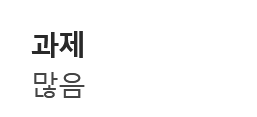

- xpath: /html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div[1]/span

case2.
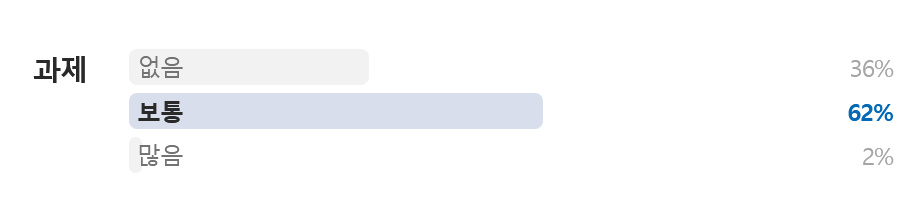

- xpath: /html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div/div[1]/div[2]
- xpath: /html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div/div[2]/div[2]
- xpath: /html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div/div[3]/div[2]


num: 2736439

url: https://everytime.kr/lecture/view/{num}

url: https://everytime.kr/lecture/view/2736439

- 점수 : .averagehtml body div div.container div.pane div.info_tab section.review div.rating div.title span.average
- 과제 : /html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div[1]/span
- 조모임 : /html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div[2]/span
- 성적 : /html/body/div/div/div[2]/div/section[2]/div[2]/div[1]/div[3]/span

---

url: https://everytime.kr/lecture/view/{num}?tab=article

- 강의평1: /html/body/div/div/div[2]/div/div[2]/div[1]/div[2]
- 강의평2: /html/body/div/div/div[2]/div/div[2]/div[2]/div[2]
- ...
- 강의평n: /html/body/div/div/div[2]/div/div[2]/div[n]/div[2]

- reviewer: /html/body/div/div/div[2]/div/div[2]/div[1]/div[1]/div[1]/div[2]/span[1]
- reviewer: /html/body/div/div/div[2]/div/div[2]/div[3]/div[1]/div[1]/div[2]/span[1]

- star: /html/body/div/div/div[2]/div/div[2]/div[{number}]/div[1]/div[1]/div[1]/span/span


In [32]:
import sqlite3
import os

db_folder = "./database"

db_path = os.path.join(db_folder, "lecture.db")

conn = sqlite3.connect(db_path)
cursor = conn.cursor()


#create test LectureTable
cursor.execute('''
CREATE TABLE IF NOT EXISTS LectureTable (
    lecNumber TEXT PRIMARY KEY,
)
''')

#create LecReviewTable
cursor.execute('''
CREATE TABLE IF NOT EXISTS LecReviewTable (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    lecNumber TEXT,
    lecReviewrs TEXT
    lecStars INTEGER,
    lecReview TEXT,
    FOREIGN KEY (lecNumber) REFERENCES LectureTable (lecNumber)
)
''')

lectures = [
    ('CS101', 'Computer Science', 'Dr. Smith'),
    ('MATH201', 'Mathematics', 'Dr. Johnson'),
    ('PHYS301', 'Physics', 'Dr. Lee')
]

reviews = [
    (1, 'CS101', 5, 'Great lecture!'),
    (2, 'CS101', 4, 'Very informative.'),
    (3, 'MATH201', 3, 'Average class.'),
    (4, 'PHYS301', 2, 'Not very engaging.'),
    (5, 'PHYS301', 1, 'Difficult to understand.')
]

cursor.executemany('''
INSERT OR IGNORE INTO LectureTable (lecNumber, lecClassification, lecProfessor)
VALUES (?, ?, ?)
''', lectures)

cursor.executemany('''
INSERT INTO LecReviewTable (id, lecNumber, lecStars, lecReview)
VALUES (?, ?, ?, ?)
''', reviews)

conn.commit()

cursor.execute('SELECT * FROM LectureTable')
print("LectureTable 데이터:")
for row in cursor.fetchall():
    print(row)

cursor.execute('SELECT * FROM LecReviewTable')
print("\nLecReviewTable 데이터:")
for row in cursor.fetchall():
    print(row)

# 연결 종료
conn.close()


LectureTable 데이터:
('CS101', 'Computer Science', 'Dr. Smith')
('MATH201', 'Mathematics', 'Dr. Johnson')
('PHYS301', 'Physics', 'Dr. Lee')

LecReviewTable 데이터:
(1, 'CS101', 5, 'Great lecture!')
(2, 'CS101', 4, 'Very informative.')
(3, 'MATH201', 3, 'Average class.')
(4, 'PHYS301', 2, 'Not very engaging.')
(5, 'PHYS301', 1, 'Difficult to understand.')
